In [35]:
# Add parent dir to path for utils access
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import rasterio 
import rioxarray as rio
import cf_xarray
import earthaccess
import seaborn as sns
import utilities.useful_functions as utils
from rasterio.enums import Resampling
from cartopy.feature import ShapelyFeature 
from cartopy.io.shapereader import Reader 

# Import water mask for plotting 
shp = "water_mask/water_mask.shp"
water_mask = ShapelyFeature(Reader(shp).geometries(), crs=ccrs.PlateCarree())

# Set up known scenes and time to search through
bbox = {"mb":(-102, 53.5, -92, 59), "la":(-120, 33, -116, 35),}
tspan_pre = ("2024-12-07", "2024-12-18")
tspan_post = ("2025-01-13", "2025-01-15")

# Define necessary specific fcns not incl'd in utils
def calc_nbr(nir, swir):
    """
    Calculates Normalized Burn Ratio given NIR and SWIR datasets
    Args:
        nir, swir - datasets of NIR and SWIR info
    Returns:
        nbr - NBR dataset
    """
    nbr = ((nir - swir) / (nir + swir))
    nbr = nbr.to_dataset(name="nbr")
    return nbr
    

In [2]:
# Set credentials
auth = earthaccess.login(persist=True)

In [3]:
# Grabbing LA pre-fire granules
# Cloud cover is whole granule, so must look at worldview to choose
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan_pre,
    bounding_box=bbox["la"],
    cloud_cover=(0, 75)
)
results[-1]

Collection: {'ShortName': 'PACE_OCI_L2_SFREFL', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 38.30287, 'Longitude': -103.18227}, {'Latitude': 32.77948, 'Longitude': -132.10988}, {'Latitude': 15.29496, 'Longitude': -125.72665}, {'Latitude': 20.41511, 'Longitude': -101.07798}, {'Latitude': 38.30287, 'Longitude': -103.18227}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-12-18T20:27:30Z', 'BeginningDateTime': '2024-12-18T20:22:31Z'}}
Size(MB): 743.6411561965942
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241218T202231.L2.SFREFL.V3_0.nc']

In [4]:
# Grab two specific prefire granules 
# (had to worldview it for clear sky over LA)
results = [results[0], results[-1]]
paths = earthaccess.open(results)
paths

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241207T203537.L2.SFREFL.V3_0.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241218T202231.L2.SFREFL.V3_0.nc>]

In [5]:
# Open, subset, and mask prefire files (~1.4 mins on cryocloud)
import time
start = time.time()
prefire_1, prefire_2 = utils.open_nc(paths[0]), utils.open_nc(paths[1])

# Subset to necessary bands only for speed
prefire_1 = prefire_1.sel({"wavelength_3d":[1038, 2131]}, method="nearest")
prefire_2 = prefire_2.sel({"wavelength_3d":[1038, 2131]}, method="nearest")

# Subset and Mask 
prefire_1, prefire_2 = utils.subset(prefire_1, bbox["la"]), utils.subset(prefire_2, bbox["la"])
prefire_1, prefire_2 = utils.mask_ds(prefire_1), utils.mask_ds(prefire_2)

# Mask for water?
prefire_1 = utils.mask_ds(prefire_1, flag="LAND", mask_reverse=True)
prefire_2 = utils.mask_ds(prefire_2, flag="LAND", mask_reverse=True)

end=time.time()
print(f"Code took {(end - start) / 60} mins to run")

Code took 1.4333696722984315 mins to run


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


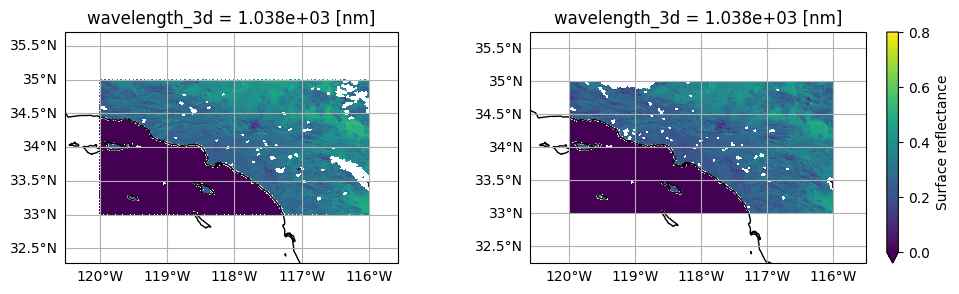

In [6]:
# Plot to make sure everything worked
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
prefire_1.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
prefire_2.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

In [7]:
# Project first prefire granule to get grid
dst = utils.reproject_3d(prefire_1["rhos"])
crs = dst.rio.crs
shape = dst.rio.shape
transform = dst.rio.transform()

# Project 2nd prefire
pf2_dst = utils.grid_match_3d(prefire_2["rhos"], 
                              crs=crs,
                              dst_shape=shape,
                              transform=transform)

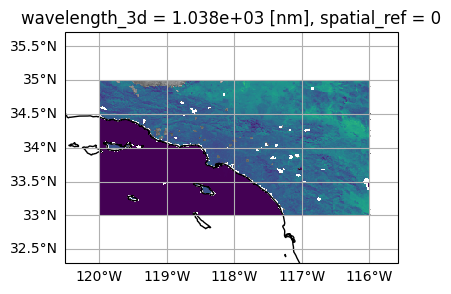

In [8]:
# Overlay to make sure datasets match
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, cmap="Greys_r", add_colorbar=False)
pf2_dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, add_colorbar=False)
plt.show()

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Code took 1.466281819343567 mins to run


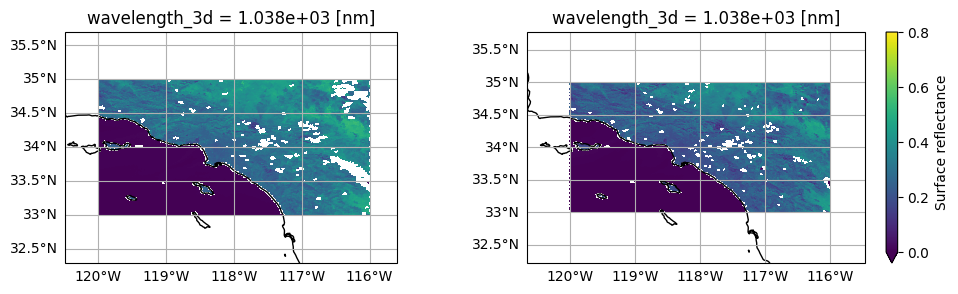

In [16]:
# Repeat the process with post-fire days
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan_post,
    bounding_box=bbox["la"],
    cloud_cover=(0, 75)
)

results = [results[0], results[-1]]
paths = earthaccess.open(results)

# Open, mask, pre-process
# Open, subset, and mask prefire files (~1.4 mins on cryocloud)
import time
start = time.time()
post_1, post_2 = utils.open_nc(paths[0]), utils.open_nc(paths[1])

# Subset to necessary bands only for speed
post_1 = post_1.sel({"wavelength_3d":[1038, 2131]}, method="nearest")
post_2 = post_2.sel({"wavelength_3d":[1038, 2131]}, method="nearest")

# Subset and Mask 
post_1, post_2 = utils.subset(post_1, bbox["la"]), utils.subset(post_2, bbox["la"])
post_1, post_2 = utils.mask_ds(post_1), utils.mask_ds(post_2)
end=time.time()
print(f"Code took {(end - start) / 60} mins to run")

# Plot to make sure everything worked
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
post_1.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
post_2.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

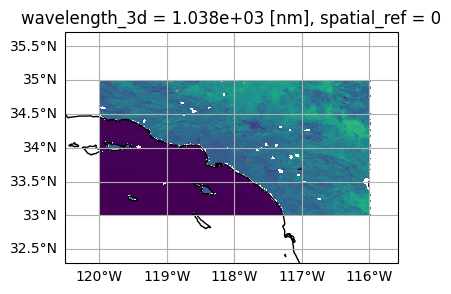

In [17]:
# Project post fire granules onto prefire grid
post1_dst = utils.grid_match_3d(post_1["rhos"], crs=crs, dst_shape=shape, transform=transform)
post2_dst = utils.grid_match_3d(post_2["rhos"], crs=crs, dst_shape=shape, transform=transform)

# Overlay all to make sure datasets match
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, cmap="Greys_r", add_colorbar=False)
pf2_dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, add_colorbar=False)
post2_dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, add_colorbar=False)
post1_dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, add_colorbar=False)
plt.show()

In [21]:
# Average NIR and SWIR over time 
pre_all = xr.combine_nested([dst, pf2_dst],concat_dim="time")
pre_mean_nir = pre_all.sel({"wavelength_3d":1038}, method="nearest").mean("time")
pre_mean_swir = pre_all.sel({"wavelength_3d":2131}, method="nearest").mean("time")

post_all = xr.combine_nested([post1_dst, post2_dst],concat_dim="time")
post_mean_nir = post_all.sel({"wavelength_3d":1038}, method="nearest").mean("time")
post_mean_swir = post_all.sel({"wavelength_3d":2131}, method="nearest").mean("time")

# Calculate NBR
pre_nbr = calc_nbr(nir=pre_mean_nir, swir=pre_mean_swir)
post_nbr = calc_nbr(nir=post_mean_nir, swir=post_mean_swir)

In [25]:
# Calculate dNBR
dnbr = pre_nbr - post_nbr
dnbr = dnbr.rename({"nbr":"dNBR"})

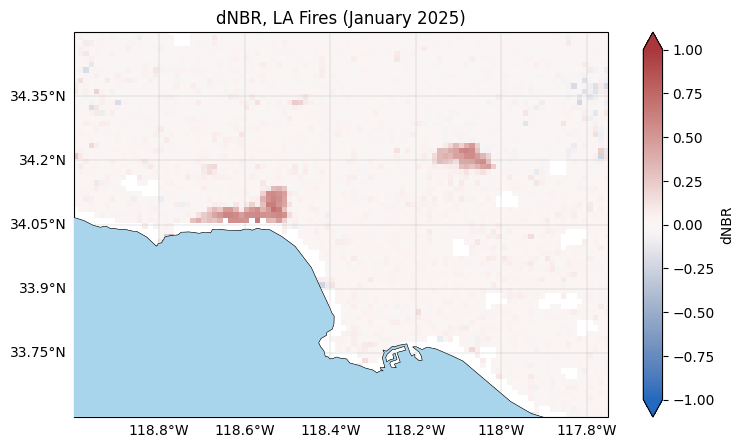

In [44]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw=
                           {"projection": ccrs.PlateCarree()})
dnbr.dNBR.plot(vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.coastlines(linewidth=0.5)
ax.add_feature(water_mask, zorder=100, facecolor='#a8d4ec', edgecolor='k', linewidth=0.25)
ax.set_extent((-119, -117.75, 33.6, 34.5), crs=ccrs.PlateCarree())
ax.set_title("dNBR, LA Fires (January 2025)")
plt.show()

In [ ]:
# Could classify as well